In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=4).start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

In [2]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print(f"Process {rank} of {size} is running")

[stdout:2] Process 2 of 4 is running


[stdout:1] Process 1 of 4 is running


[stdout:0] Process 0 of 4 is running


[stdout:3] Process 3 of 4 is running


In [3]:
%%px
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

from tqdm import tqdm

In [4]:
%%px
# ---------- Domain setup ---------

# Geometry & Materials
solid_1 = 'notebooks/data/002_vacuum_cavity.stl'
solid_2 = 'notebooks/data/002_lossymetal_shell.stl'

stl_solids = {'cavity': solid_1, 
              'shell': solid_2
              }

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30] #[eps_r, mu_r, sigma[S/m]]
                 }

# Extract domain bounds from geometry
solids = pv.read(solid_1) + pv.read(solid_2)
xmin, xmax, ymin, ymax, zmin, zmax = solids.bounds

# Number of mesh cells
Nx = 80
Ny = 80
Nz = 141

# Adjust for MPI & ompute local Z-slice range
Nz += Nz%(size) #if rank 0 is common, then size-1
dz = (zmax - zmin) / Nz
z = np.linspace(zmin, zmax, Nz+1)

# Allocate mpi node cells
Nz_mpi = Nz // (size) 
zmin_mpi = rank * Nz_mpi * dz + zmin
zmax_mpi= (rank+1) * Nz_mpi * dz + zmin

print(f"Process {rank}: Handling Z range {zmin_mpi} to {zmax_mpi}")
print(solids.bounds)


[stdout:1] Process 1: Handling Z range -0.05281689847019358 to 0.14436620305961284
(-0.25999999046325684, 0.25999999046325684, -0.25999999046325684, 0.25999999046325684, -0.25, 0.550000011920929)


[stdout:0] Process 0: Handling Z range -0.25 to -0.05281689847019358
(-0.25999999046325684, 0.25999999046325684, -0.25999999046325684, 0.25999999046325684, -0.25, 0.550000011920929)


[stdout:2] Process 2: Handling Z range 0.14436620305961284 to 0.34154930458941934
(-0.25999999046325684, 0.25999999046325684, -0.25999999046325684, 0.25999999046325684, -0.25, 0.550000011920929)


[stdout:3] Process 3: Handling Z range 0.34154930458941934 to 0.5387324061192257
(-0.25999999046325684, 0.25999999046325684, -0.25999999046325684, 0.25999999046325684, -0.25, 0.550000011920929)


In [5]:
%%px
grid = GridFIT3D(xmin, xmax, ymin, ymax, 
                zmin_mpi, zmax_mpi, 
                Nx, Ny, Nz_mpi, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0,
                stl_rotate=[0,0,0],
                stl_translate=[0,0,0],
                verbose=1)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] Generating grid...
Importing stl solids...


[stdout:3] Generating grid...
Importing stl solids...


[stdout:1] Generating grid...
Importing stl solids...


[stdout:2] Generating grid...
Importing stl solids...


In [6]:
%%px
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

if rank > 0:
    bc_low=['pec', 'pec', 'periodic']

if rank < size - 1:
    bc_high=['pec', 'pec', 'periodic']

# Solver setup
solver = SolverFIT3D(grid,
                    bc_low=bc_low, 
                    bc_high=bc_high, 
                    use_stl=True, 
                    bg='pec' # Background material
                    )

if rank == 0:
    img_folder = 'notebooks/005_img/'
    if not os.path.exists(img_folder): 
        os.mkdir(img_folder)

[stdout:3] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.9730184078216553 s


[stdout:2] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.046703577041626 s


[stdout:0] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.94777512550354 s


[stdout:1] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.1294543743133545 s


[stdout:1] ['pec', 'pec', 'periodic']
['pec', 'pec', 'periodic']


[stdout:2] ['pec', 'pec', 'periodic']
['pec', 'pec', 'periodic']


[stdout:0] ['pec', 'pec', 'pec']
['pec', 'pec', 'periodic']


[stdout:3] ['pec', 'pec', 'periodic']
['pec', 'pec', 'pec']


[output:1]

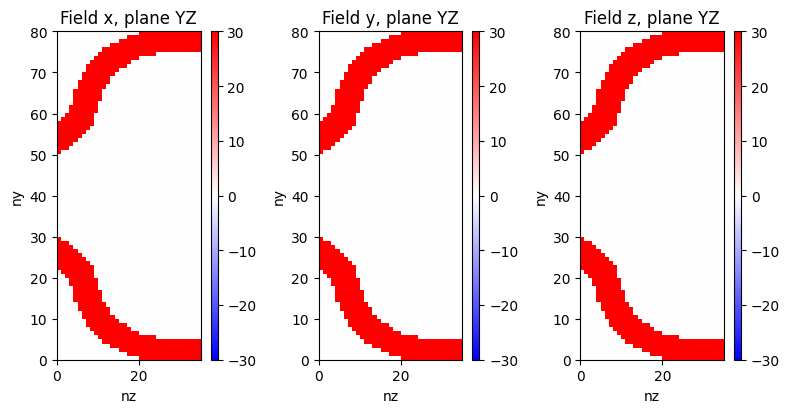

[output:0]

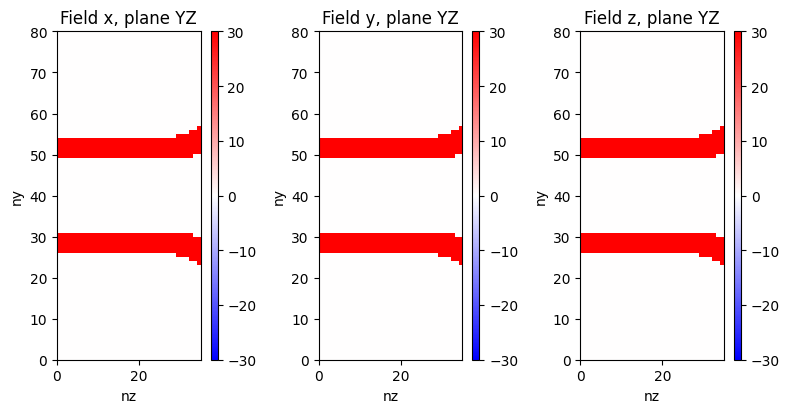

[output:3]

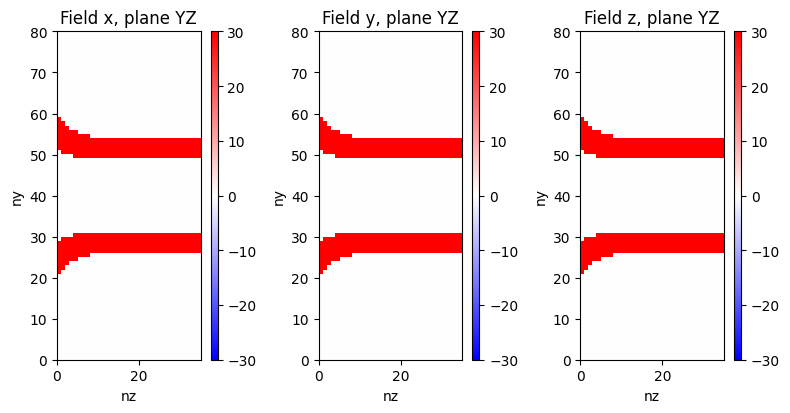

[output:2]

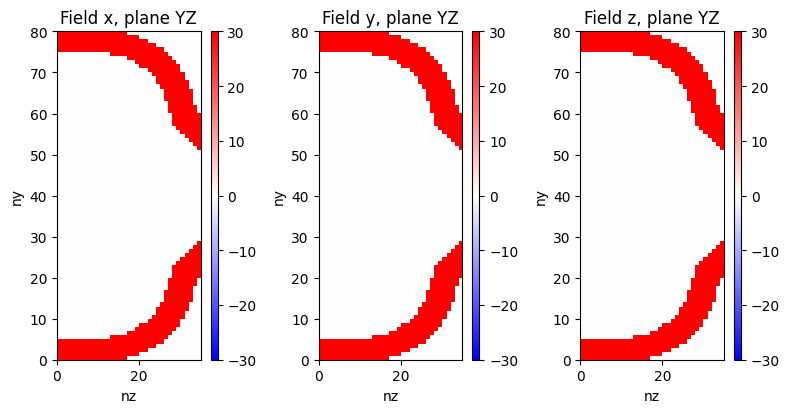

In [7]:
%%px
for n in range(size):
    if rank==n:
        print(solver.bc_low)
        print(solver.bc_high)
        solver.sigma.inspect()

In [8]:
%%px
# ------------ Beam source & Wake ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 10. # [m]
add_space = 10   # no. cells to skip from boundaries - removes BC artifacts

from wakis.sources import Beam
from scipy.constants import c
beam = Beam(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys, ti=3*sigmaz/c)

In [9]:
%%px
def communicate_ghost_cells():
    if rank > 0:
        for d in ['x','y','z']:
            comm.Sendrecv(solver.E[:, :, 1,d], 
                        recvbuf=solver.E[:, :, 0,d],
                        dest=rank-1, sendtag=0,
                        source=rank-1, recvtag=1)

            comm.Sendrecv(solver.H[:, :, 1,d], 
                        recvbuf=solver.H[:, :, 0,d],
                        dest=rank-1, sendtag=0,
                        source=rank-1, recvtag=1)
            
            comm.Sendrecv(solver.J[:, :, 1,d], 
                        recvbuf=solver.J[:, :, 0,d],
                        dest=rank-1, sendtag=0,
                        source=rank-1, recvtag=1)
            
    if rank < size - 1:
        for d in ['x','y','z']:
            comm.Sendrecv(solver.E[:, :, -2,d], 
                          recvbuf=solver.E[:, :, -1, d], 
                          dest=rank+1, sendtag=1,
                          source=rank+1, recvtag=0)
            
            comm.Sendrecv(solver.H[:, :, -2,d], 
                          recvbuf=solver.H[:, :, -1, d], 
                          dest=rank+1, sendtag=1,
                          source=rank+1, recvtag=0)
            
            comm.Sendrecv(solver.J[:, :, -2,d], 
                          recvbuf=solver.J[:, :, -1, d], 
                          dest=rank+1, sendtag=1,
                          source=rank+1, recvtag=0)


In [10]:
%%px
def compose_field_E(d='z'):
    global E
    local = solver.E[Nx//2, :, :,d].ravel()
    buffer = comm.gather(local, root=0)

    if rank == 0:
        E = np.zeros((Ny, Nz))  # Reinitialize global array
        for r in range(size):
            E[:, r*Nz_mpi:(r+1)*Nz_mpi] = np.reshape(buffer[r], (Ny, Nz_mpi))

In [11]:
%%px
def compose_field_H(d='z'):
    global H
    local = solver.H[Nx//2, :, :,d].ravel()
    buffer = comm.gather(local, root=0)

    if rank == 0:
        H = np.zeros((Ny, Nz))
        for r in range(size):
            H[:, r*Nz_mpi:(r+1)*Nz_mpi] = np.reshape(buffer[r], (Ny, Nz_mpi))

In [12]:
%%px
def compose_field_J(d='z'):
    global J
    local = solver.J[Nx//2, :, :,d].ravel()
    buffer = comm.gather(local, root=0)

    if rank == 0:
        J = np.zeros((Ny, Nz))
        for r in range(size):
            J[:, r*Nz_mpi:(r+1)*Nz_mpi] = np.reshape(buffer[r], (Ny, Nz_mpi))

In [13]:
%%px
def compose_field(field, d='z'):

    if field == 'E':
        local = solver.E[Nx//2, :, :,d].ravel()
    elif field == 'H':
        local = solver.H[Nx//2, :, :,d].ravel()
    elif field == 'J':
        local = solver.J[Nx//2, :, :,d].ravel()

    buffer = comm.gather(local, root=0)
    field = None

    if rank == 0:
        field = np.zeros((Ny, Nz))  # Reinitialize global array
        for r in range(size):
            field[:, r*Nz_mpi:(r+1)*Nz_mpi] = np.reshape(buffer[r], (Ny, Nz_mpi))
    
    return field

In [14]:
%%px
def plot_field(field, name='E', n=None, results_folder='img/'):
    extent = (zmin, zmax, ymin, ymax)
    fig, ax = plt.subplots()
    im = ax.imshow(field, cmap='bwr', extent=extent, vmin=-500, vmax=500)
    fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_title(f'{name} at timestep={n}')
    ax.set_xlabel('z [m]')
    ax.set_ylabel('y [m]')

    fig.tight_layout(h_pad=0.3)
    fig.savefig(results_folder+name+str(n).zfill(4)+'.png')
    plt.close(fig)

In [15]:
%%px
n = 0
solver.reset_fields()

In [ ]:
%%px
Nt = 3000
for n in tqdm(range(Nt)):
    beam.update_mpi(solver, n*solver.dt, zmin)

    solver.one_step()

    communicate_ghost_cells()

    if n%20 == 0:
        Ez = compose_field('E')
        if rank == 0:
            plot_field(Ez, 'Ez', n=n, results_folder=img_folder)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [ ]:
%%px
compose_field_E()
if rank == 0:
    plt.imshow(E)

In [ ]:
%%px
compose_field_H()
if rank == 0:
    plt.imshow(H)

In [ ]:
%%px
compose_field_J()
if rank == 0:
    plt.imshow(J)